In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from IPython.display import display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pl
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import xgboost as xgb
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Pretty display for notebooks
%matplotlib inline

# Any results you write to the current directory are saved as output.

In [26]:
#print(features_raw[features_raw.child_on_acc_pre_school.notnull()].head(1))
#print(features_raw.info())
def col_convert(df):
    columns_convert = df.select_dtypes(include=[object]).keys()
    df[columns_convert]= df[columns_convert].apply(lambda x: pd.to_numeric(x.astype(str)
                                                                          .str.replace(',','.'), errors='ignore'))
    return df
def replace_mfloor(x,floor):
    if (np.isnan(x)) or( x == 0)or( x == 1):
        return floor
    else:
        return x
def replace_floor(x,mfloor):
    if x > mfloor:
        if 10 < x < 100:
            return int(x / 10)
        elif x > 100:
            return int(x / 100)
        else:
            return mfloor       
    else:
        return x
def replace_build(x):
    if (np.isnan(x)) or( x == 0):
        return -99
    elif x == 20052009:
        return 2007
    elif x == 4965:
        return 1965
    elif x <= 20:
        return 2000 + x
    elif x < 100:
        return 1900 + x
    elif x < 220:
        return 1800 + x
    else:
        return x
def replace_with_median(x,median):
    if (np.isnan(x)) or( x == 0)or( x == 1):
        return median
    else:
        return x
def fix_state(x):
    if x ==33:
        return 3
    else:
        return x
def fill_median(df1,df2,numerical):
    for f in numerical:
        values = list(df1[f].values) + list(df2[f].values)
        median = np.nanmedian(values)
        #print(f,median)
        df1[f] = df1[f].fillna(median)
        df1[f] = df1[f].replace(0, median)
        df2[f] = df2[f].fillna(median)
        df2[f] = df2[f].replace(0, median)
    return df1,df2


In [28]:
data = pd.read_csv("train.csv", parse_dates=['timestamp'], index_col ='id')
prices = data['price_doc']
train_data = data.drop(['price_doc'], axis =1)
display(train_data.head())
macros = pd.read_csv("macro.csv",parse_dates=['timestamp'])
#prepare test data:
test_data = pd.read_csv("test.csv", parse_dates=['timestamp'])
id_test = test_data.id
test_data.drop(['id'], axis =1, inplace = True)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,40,9,4,0,13,22,1,0,52,4
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,36,15,3,0,15,29,1,10,66,14
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25,10,3,0,11,27,0,4,67,10
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,11,2,1,4,4,0,0,26,3
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,552,319,108,17,135,236,2,91,195,14


In [30]:
macros_raw = col_convert(macros)
macros_raw = macros_raw.replace('#!',-99)
macros_raw['child_on_acc_pre_school'] = macros_raw['child_on_acc_pre_school'].replace(',','').astype(float)
macros_raw['modern_education_share'] = macros_raw['modern_education_share'].astype(float)
macros_raw['old_education_build_share'] = macros_raw['old_education_build_share'].astype(float)
macros_raw = macros_raw.drop('timestamp',axis=1)
macros_raw = macros_raw.fillna(0)
macro_col =  pd.read_csv("macro_dropped.csv")
col_drop = list(macro_col['features'].values)
macros_raw = macros_raw.drop(col_drop, axis = 1)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            # Loop repeatedly until we find that all columns within our dataset
            # have a VIF value we're happy with.
            variables = X.columns
            dropped=False
            vif = []
            new_vif = 0
            for var in X.columns:
                new_vif = variance_inflation_factor(X[variables].values, X.columns.get_loc(var))
                vif.append(new_vif)
                if np.isinf(new_vif):
                    break
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print('Dropping {} with vif= {}'.format(X.columns[maxloc],max_vif))
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [34]:

#transformer = ReduceVIF()
#macros_raw = transformer.fit_transform(macros_raw, macros_raw.columns)
#macros_raw.head()

In [36]:
macros_raw['timestamp'] = macros['timestamp']

In [38]:
feature_full = train_data.reset_index().merge(macros_raw, on='timestamp' ,how="left").set_index('id')
test_features_raw = test_data.merge(macros_raw, on='timestamp', how='left')

display(feature_full.head())

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,leisure_count_5000,sport_count_5000,market_count_5000,gdp_quart_growth,balance_trade_growth,net_capital_export,deposits_growth,mortgage_value,mortgage_growth,students_reg_sports_share
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,52,4,3.3,10.1,0.301811,0.009740,323275,1.051914,64.12
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,66,14,3.3,10.1,0.301811,0.009740,323275,1.051914,64.12
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4,67,10,3.3,10.1,0.301811,0.009740,323275,1.051914,64.12
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,26,3,3.3,10.1,0.599709,0.009607,386388,1.049543,64.12
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,91,195,14,3.3,10.1,0.599709,0.018590,386388,1.049543,64.12


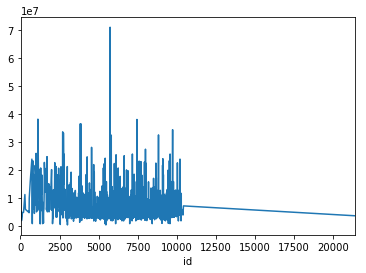

In [40]:
bad_data = feature_full[['full_sq','life_sq','kitch_sq','max_floor','floor']]
bad_data = bad_data.replace(1,0)

bad_data['life'] = bad_data['full_sq'] - bad_data['life_sq']
bad_data['kitchen'] = bad_data['full_sq'] - bad_data['kitch_sq']
bad_data['lk'] = bad_data['life_sq'] - bad_data['kitch_sq']
bad_data['fl'] = bad_data['max_floor'] - bad_data['floor']

bad_data = bad_data.fillna(-1)
matches = (bad_data['life'] <= 0) & (bad_data['kitchen'] <= 0 ) & (bad_data['lk'] < 0) & (bad_data['fl'] < 0)
#display(bad_data.loc[matches.index[matches == True]])
        
#display(feature_full.loc[matches.index[matches == True]])
index_drop = feature_full.loc[matches.index[matches == True]]
display(prices.loc[index_drop.index].plot())

In [42]:
features_raw = feature_full.drop(index_drop.index,errors = 'ignore')
prices = prices.drop(index_drop.index,errors = 'ignore')
full_sq_avg = np.nanmedian(features_raw['full_sq'])
life_sq_avg =  np.nanmedian(features_raw['life_sq'])
kitch_sq_avg = np.nanmedian(features_raw['kitch_sq'])
life_ratio = life_sq_avg / full_sq_avg
kitch_ratio = kitch_sq_avg / full_sq_avg
print (life_ratio,kitch_ratio)

0.625 0.125


In [44]:
#fix training
features_raw['full_sq']= features_raw.apply(lambda row: replace_with_median(row['full_sq'],full_sq_avg), axis=1)
features_raw['life_sq']= features_raw.apply(lambda row: replace_with_median(row['life_sq'],life_sq_avg), axis=1)
features_raw['kitch_sq']= features_raw.apply(lambda row: replace_with_median(row['kitch_sq'],kitch_sq_avg), axis=1)

features_raw[['floor']] = features_raw[['floor']].fillna(value=0)
features_raw['max_floor']= features_raw.apply(lambda row: replace_mfloor(row['max_floor'],row['floor']), axis=1)
features_raw['floor']= features_raw.apply(lambda row: replace_floor(row['floor'],row['max_floor']), axis=1)
features_raw['build_year'] = features_raw.apply(lambda row: replace_build(row['build_year']), axis=1)
features_raw['build_age'] = 2020 - features_raw['build_year']
features_raw['build_age'] = features_raw['build_age'].replace(2119,-99)
features_raw['flor_prop'] =  (features_raw['floor'] + 1) / (features_raw['max_floor'] + 1)
features_raw['state'] = features_raw.apply(lambda row: fix_state(row['state']), axis=1)
features_raw["year"] = features_raw["timestamp"].dt.year
features_raw["yearmonth"] = features_raw["timestamp"].dt.year*100 + features_raw["timestamp"].dt.month

#fix testing
test_features_raw['full_sq']= test_features_raw.apply(lambda row: replace_with_median(row['full_sq'],full_sq_avg), axis=1)
test_features_raw['life_sq']= test_features_raw.apply(lambda row: replace_with_median(row['life_sq'],life_sq_avg), axis=1)
test_features_raw['kitch_sq']= test_features_raw.apply(lambda row: replace_with_median(row['kitch_sq'],kitch_sq_avg), axis=1)

test_features_raw[['floor']] = test_features_raw[['floor']].fillna(value=0)
test_features_raw['max_floor']= test_features_raw.apply(lambda row: replace_mfloor(row['max_floor'],row['floor']), axis=1)
test_features_raw['floor']= test_features_raw.apply(lambda row: replace_floor(row['floor'],row['max_floor']), axis=1)
test_features_raw['build_year'] = test_features_raw.apply(lambda row: replace_build(row['build_year']), axis=1)
test_features_raw['build_age'] = 2020 - features_raw['build_year']
test_features_raw['build_age'] = test_features_raw['build_age'].replace(2119,-99)
test_features_raw['flor_prop'] =  (test_features_raw['floor'] +1) / (test_features_raw['max_floor'] + 1)
test_features_raw['state'] = test_features_raw.apply(lambda row: fix_state(row['state']), axis=1)


test_features_raw["year"] = test_features_raw["timestamp"].dt.year
test_features_raw["yearmonth"] = test_features_raw["timestamp"].dt.year*100 + test_features_raw["timestamp"].dt.month

In [46]:
display(features_raw['material'].unique() )
display(features_raw['state'].unique() )
features_raw.drop('timestamp',axis=1,inplace =True)
test_features_raw.drop('timestamp',axis=1,inplace =True)

array([ nan,   1.,   2.,   4.,   6.,   5.,   3.])

array([ nan,   3.,   1.,   2.,   4.])

In [48]:
objects = list(features_raw.select_dtypes(include=['object']).columns)
objects.remove('product_type')
objects.remove('sub_area')
#training 
features = col_convert(features_raw)
features[objects] = features[objects].fillna(-99)
features[objects] = features[objects].replace('nan',-99)
features[['material','state']] = features[['material','state']].fillna(-99)
features['ecology'] = features['ecology'].replace('no data',-99)

#testing
test_features = col_convert(test_features_raw)
test_features[objects] = test_features[objects].fillna(-99)
test_features[objects] = test_features[objects].replace('nan',-99)
test_features[['material','state']] = test_features[['material','state']].fillna(-99)
test_features['ecology'] = test_features['ecology'].replace('no data',-99)

In [50]:
#one hot encode these features:
pt_cat = set(list(features['product_type'].values) + list(test_features['product_type']))

features['product_type'] = features['product_type'].astype('category',categories= pt_cat)
test_features['product_type'] = test_features['product_type'].astype('category',categories= pt_cat)

train_dummy  = pd.get_dummies(features['product_type'])
test_dummy  = pd.get_dummies(test_features['product_type'])

features = features.join(train_dummy)
features = features.drop(['product_type','nan'], axis =1)

test_features = test_features.join(test_dummy)
test_features = test_features.drop(['product_type','nan'] , axis =1)

columns = features.columns
test_columns = test_features.columns
for i in range(len(columns)):
    if columns[i] != test_columns[i]:
        print ('error at training: {} testing: {}'.format(columns[i],test_columns[i]))

In [52]:
#one hot encode these features:
sb_cat = set(list(features['sub_area'].values) + list(test_features['sub_area']))

features['sub_area'] = features['sub_area'].astype('category',categories= sb_cat)
test_features['sub_area'] = test_features['sub_area'].astype('category',categories= sb_cat)

train_dummy  = pd.get_dummies(features['sub_area'])
test_dummy  = pd.get_dummies(test_features['sub_area'])

features = features.join(train_dummy)
features = features.drop('sub_area', axis =1)

test_features = test_features.join(test_dummy)
test_features = test_features.drop('sub_area', axis =1)

columns = features.columns
test_columns = test_features.columns
for i in range(len(columns)):
    if columns[i] != test_columns[i]:
        print ('error at training: {} testing: {}'.format(columns[i],test_columns[i]))

In [54]:
#encode the 'features' data with label encored
from sklearn.preprocessing import LabelEncoder

features_encoded = features
test_features_encoded = test_features
# Encoding the variable
for f in objects:
    print(f)
    lbl = LabelEncoder()
    listing  = list(features[f].values.astype('str')) 
    listing.extend(list(test_features[f].values.astype('str')))
    #print (set(listing))
    lbl.fit(listing)
    features_encoded[f] = lbl.transform(list(features[f].values.astype('str')))
    test_features_encoded[f] = lbl.transform(list(test_features[f].values.astype('str')))
# Print the number of features after one-hot encoding
encoded = list(features_encoded.columns)
print ("{} total features after encoding.".format(len(encoded)))

culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
446 total features after encoding.


In [56]:
numerical = list(features_encoded.select_dtypes(include=['float64','int64']).keys())
numerical.remove('material')
numerical.remove('state')

#features_encoded = features_encoded.fillna(-99)
#test_features_encoded = test_features_encoded.fillna(-99)
features_encoded , test_features_encoded = fill_median(features_encoded,test_features_encoded,numerical)
#display(features_encoded[numerical].describe())
numerical.remove('yearmonth')
#features_encoded[numerical] = scaler.fit_transform(features_encoded[numerical])
#test_features_encoded[numerical] = scaler.transform(test_features_encoded[numerical])

In [58]:
#dropped
feat_col =  pd.read_csv("columns_dropped.csv")
col_drop = list(feat_col['features'].values)

features_dropped = features_encoded[col_drop]
test_features_dropped = test_features_encoded[col_drop]

In [60]:
#removed from training data
#transformer = ReduceVIF()
#best_features = transformer.fit_transform(features_encoded, features_encoded.columns)
#best_features.head()
#best_test_features = test_features_encoded[best_features.columns]

In [62]:
#save data 
import pickle
#pickle.dump((best_features, prices), open('train_encoded.p', 'wb'))
#pickle.dump((best_test_features), open('test_encoded.p', 'wb'))
pickle.dump((features_encoded.drop(col_drop,axis=1), prices), open('train_encoded.p', 'wb'))
pickle.dump((test_features_encoded.drop(col_drop,axis=1)), open('test_encoded.p', 'wb'))
#import geopandas as gpd
#geo_df = gpd.read_file('../data/external/Kaggle_SRHM/shp_mo_kag_SRHM')
#geo_df['geometry'].plot()

In [64]:
# Load the Preprocessed data
import pickle
best_features, prices = pickle.load(open('train_encoded.p', mode='rb'))
best_test_features = pickle.load(open('test_encoded.p', mode='rb'))

columns = best_features.columns
test_columns = best_test_features.columns
for i in range(len(columns)):
    if columns[i] != test_columns[i]:
        print ('error at training: {} testing: {}'.format(columns[i],test_columns[i]))

#features_encoded = features_encoded.fillna(-1)
#test_features_encoded = test_features_encoded.fillna(-1)
from sklearn.feature_selection import SelectKBest,f_regression
kbest = SelectKBest(score_func=f_regression,k=100)
best_features = kbest.fit_transform(features_encoded,prices)
best_test_features = kbest.transform(test_features_encoded)

#print(best_features)
keep_features = np.sort(kbest.scores_)[::-1]

keep_features = keep_features[np.where(kbest.scores_ > 1e-03 )]
print (len(keep_features))

Dimension_1    0.8756
Dimension_2    0.9486
Dimension_3    1.0000
Name: Explained Variance, dtype: float64

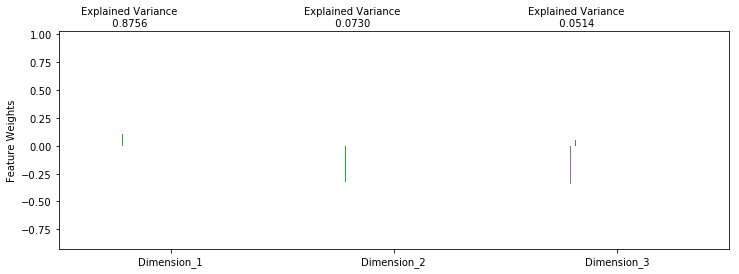

In [66]:
#pca explanation
def pca_results(good_data, pca, ind):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension_{}'.format(i+ind) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = pl.subplots(figsize = (12,4))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar', legend = False);
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

pca = PCA(n_components=3,random_state=33).fit(best_features)

pca_result = pca_results(best_features,pca,0)

pca_result['Explained Variance'].cumsum()

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Dimension_1    0.5901
Dimension_2    0.9465
Dimension_3    1.0000
Name: Explained Variance, dtype: float64

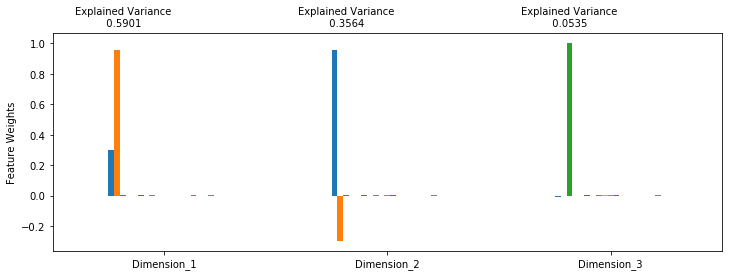

In [68]:
#train_prices = np.log1p(prices)
train_prices = prices
kbest = SelectKBest(k = 19 )
kfeat = kbest.fit_transform(best_features, train_prices)
kfeat_test = kbest.transform(best_test_features)
pca = PCA(n_components=3,random_state=33).fit(kfeat)

kbest_col = best_features.columns[kbest.get_support()].tolist()

pca_result = pca_results(best_features[kbest_col],pca,0)

top_20_pca = pd.DataFrame(pca.transform(kfeat), columns = pca_result.index, index=best_features.index)
top_20_pca_test = pd.DataFrame(pca.transform(kfeat_test), columns = pca_result.index)
pca_result['Explained Variance'].cumsum()

Dimension_4    0.8756
Dimension_5    0.9486
Dimension_6    1.0000
Name: Explained Variance, dtype: float64

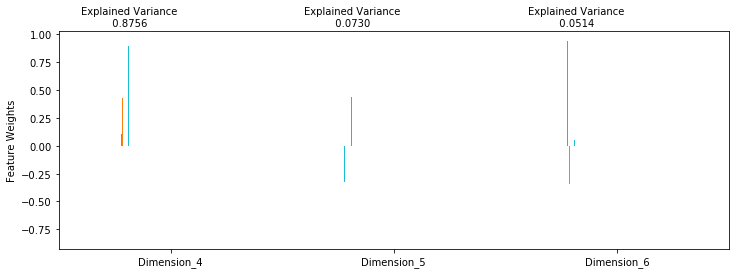

In [70]:
pca = PCA(n_components=3,random_state=33).fit(best_features.drop(kbest_col, axis =1))

pca_result = pca_results(best_features.drop(kbest_col, axis =1),pca,3)

kept_pca = pd.DataFrame(pca.transform(best_features.drop(kbest_col, axis =1)), columns = pca_result.index, index=best_features.index)
kept_pca_test = pd.DataFrame(pca.transform(best_test_features.drop(kbest_col, axis =1)), columns = pca_result.index)
pca_result['Explained Variance'].cumsum()

Dimension_7     0.9795
Dimension_8     0.9971
Dimension_9     0.9983
Dimension_10    0.9989
Dimension_11    0.9993
Dimension_12    0.9996
Dimension_13    0.9998
Dimension_14    0.9999
Dimension_15    1.0000
Name: Explained Variance, dtype: float64

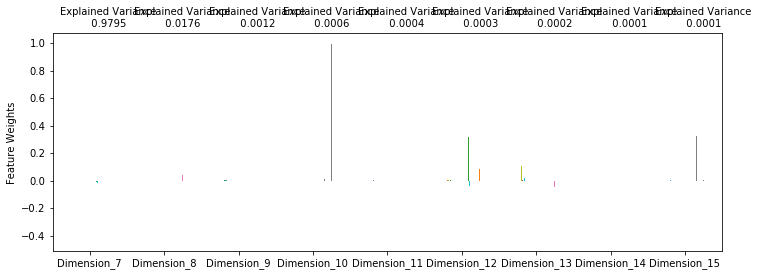

In [72]:
pca = PCA(n_components=9,random_state=33).fit(features_dropped)

pca_result = pca_results(features_dropped,pca,6)

pca_features_dropped = pd.DataFrame(pca.transform(features_dropped), columns = pca_result.index, index = features_dropped.index)
pca_test_features_dropped = pd.DataFrame(pca.transform(test_features_dropped), columns = pca_result.index)

pca_result['Explained Variance'].cumsum()

In [147]:
#from sklearn.pipeline import FeatureUnion

# Build estimator from PCA and Univariate selection:
from sklearn.feature_selection import SelectPercentile,f_regression

percent = SelectPercentile(score_func=f_regression, percentile=1).fit(best_features,train_prices)

train_percentile = pd.DataFrame(percent.transform(best_features),columns =best_features.columns[percent.get_support()],index = best_features.index)
# Use combined features to transform dataset:

X_features = train_percentile.join(pca_features_dropped, rsuffix='pca_dropped')

X_features = X_features.join(top_20_pca, rsuffix='pca_top')

X_features = X_features.join(kept_pca, rsuffix='pca_kept')

#ordering columns
col_order = X_features.columns.tolist()
col_order = sorted(col_order)
X_features = X_features[col_order]


#X_features = X_features[col_order]
#display (X_features.head())

test_percentile = pd.DataFrame(percent.transform(best_test_features),columns = best_test_features.columns[percent.get_support()])
    
submit_features = test_percentile.join(pca_test_features_dropped, rsuffix='pca_dropped')

submit_features = submit_features.join(top_20_pca_test, rsuffix='pca_top')

submit_features = submit_features.join(kept_pca_test, rsuffix='pca_kept')

#ordering columns
submit_features = submit_features[col_order]
#display (submit_features.head())

In [149]:
columns = X_features.columns
test_columns = submit_features.columns
for i in range(len(columns)):
    if columns[i] != test_columns[i]:
        print ('error at training: {} testing: {}'.format(columns[i],test_columns[i]))

In [158]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

Kr = KNeighborsRegressor()

from sklearn.pipeline import Pipeline

scaler = StandardScaler()

scalerKr = Pipeline([('scaler', scaler), ('Kr', Kr)])

scalersvm = Pipeline([('scaler', scaler), ('lin', SVR(kernel='rbf'))])

scalerKr = scalerKr.fit(X_features,train_prices)

kr_train = pd.DataFrame(scalerKr.predict(X_features), columns = ['knn'], index = X_features.index)
#print(X_train.shape, kr_train.shape)
X_train = X_features.join(kr_train)

kr_test = pd.DataFrame(scalerKr.predict(submit_features), columns = ['knn'], index = submit_features.index)
Xtest1 = submit_features.join(kr_test)

scalersvm = scalersvm.fit(X_features,train_prices)

svm_train = pd.DataFrame(scalersvm.predict(X_features), columns = ['svm'], index = X_features.index)
#print(X_train.shape, svm_train.shape)
X_train = X_train.join(svm_train )

svm_test = pd.DataFrame(scalersvm.predict(submit_features), columns = ['svm'], index = submit_features.index)
Xtest1 = Xtest1.join(svm_test )
#display (X_train1.head())

In [159]:
import random
val_time = 201501

columns = X_train  
#[features_encoded.columns[kbest.get_support()]]
test_columns = Xtest1.columns
#[test_features_encoded.columns[kbest.get_support()]]
display()
#columns = features_keep
#test_columns = features_keep

df_temporal = X_train.join(features_raw.yearmonth, how = 'inner')


#dev_indices = np.where(features_raw["yearmonth"]<= val_time)
val_indices = np.where(df_temporal["yearmonth"] > val_time)


df_eval = feature_full.merge(X_train, how = 'inner', left_index =True, right_index =True)
df_eval = df_eval.dropna(axis=0, how='any')
eval_index = random.sample(set(df_eval.index),10)

x_eval_set  = X_train.loc[eval_index]
y_eval_set = train_prices.loc[eval_index]


dev_X = X_train.drop(eval_index)
dev_y = train_prices.drop(eval_index)


val_X = X_train.iloc[val_indices]
val_y = train_prices.iloc[val_indices]




print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)
print(x_eval_set.shape, y_eval_set.shape)

(27245, 19) (27245,)
(2819, 19) (2819,)
(10, 19) (10,)


In [160]:
def sample_vals(df, price_value, ratio, condition, seed):
    indices = condition(df.price_doc, price_value) & (df.product_type == 'Investment') & (df.timestamp < '2015-01-01') & (df.timestamp>='2011-10-01')
    df_resampled = df.loc[indices].sample(frac=ratio, random_state=seed)
    df_remaining = df.loc[~indices]
    df_new = pd.concat([df_resampled, df_remaining], axis=0)
    return df_new

from operator import eq, le

timedf = feature_full[['timestamp', 'product_type']]

trainsub = X_train.join(timedf, how = 'inner')

train = trainsub.join(prices, how='inner')

train = sample_vals(train, 1000000, 0.1, le, seed=1)
train = sample_vals(train, 2000000, 0.3, eq, seed=1)
train = sample_vals(train, 3000000, 0.5, eq, seed=1)

x_val = train.drop(['timestamp','product_type','price_doc'], axis =1)
y_val = np.log1p(train.price_doc)
                   

print(x_val.shape, y_val.shape)

(25814, 19) (25814,)


In [161]:
#optimising mode
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.47,
    'objective': 'reg:linear',
    'lambda' : 0.1,
    'alpha' : 0.01,
   # 'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight' : 7,
    'seed' :33
}
from sklearn.metrics import make_scorer,mean_squared_error
def RMSLE(ypred,Y):
    labels = Y.get_label()
    return 'error',np.sqrt(mean_squared_error(np.log1p(labels), np.log1p(ypred)))
                   
scoring = make_scorer(RMSLE)

In [162]:
xgtrain = xgb.DMatrix(dev_X, dev_y,  feature_names =dev_X.columns, missing = -99)
xgtest = xgb.DMatrix(val_X, val_y, feature_names=val_X.columns, missing = -99)
xgval = xgb.DMatrix(x_val, y_val, feature_names=x_val.columns, missing = -99)
xgeval =  xgb.DMatrix(x_eval_set, y_eval_set, feature_names=x_eval_set.columns, missing = -99)

watchlist = [ (xgtest,'temporal'),(xgeval, 'validation') ]
xgall = xgb.DMatrix(X_train,train_prices, feature_names = X_train.columns, missing = -99)
xg_submit = xgb.DMatrix(Xtest1,feature_names = Xtest1.columns, missing = -99 )

In [163]:
num_rounds = 1200
model = xgb.train(xgb_params, xgall, num_rounds, watchlist,feval =RMSLE, maximize=False,  verbose_eval=50)

[0]	temporal-error:3.92421	validation-error:3.86955
[50]	temporal-error:0.567072	validation-error:0.73886
[100]	temporal-error:0.391767	validation-error:0.642596
[150]	temporal-error:0.367063	validation-error:0.642522
[200]	temporal-error:0.360662	validation-error:0.643013
[250]	temporal-error:0.357943	validation-error:0.643869
[300]	temporal-error:0.355966	validation-error:0.644181
[350]	temporal-error:0.354693	validation-error:0.644058
[400]	temporal-error:0.353444	validation-error:0.642614
[450]	temporal-error:0.352571	validation-error:0.642155
[500]	temporal-error:0.351577	validation-error:0.641755
[550]	temporal-error:0.350829	validation-error:0.636609
[600]	temporal-error:0.35029	validation-error:0.636349
[650]	temporal-error:0.349432	validation-error:0.635143
[700]	temporal-error:0.348734	validation-error:0.635242
[750]	temporal-error:0.347962	validation-error:0.632977
[800]	temporal-error:0.347267	validation-error:0.634131
[850]	temporal-error:0.346627	validation-error:0.633167

[0]	train-error:3.86436+0.000558137	test-error:3.86456+0.0078526
[50]	train-error:0.577444+0.00234905	test-error:0.580939+0.00280881
[100]	train-error:0.457723+0.00400267	test-error:0.464504+0.00688764
[150]	train-error:0.450338+0.003844	test-error:0.459024+0.00827049
[200]	train-error:0.44901+0.00374843	test-error:0.459242+0.00854722
[250]	train-error:0.447323+0.00348432	test-error:0.45896+0.00893012
[300]	train-error:0.445663+0.00320003	test-error:0.458425+0.00915572
[350]	train-error:0.443942+0.0030404	test-error:0.457859+0.00924926
[400]	train-error:0.442296+0.00290768	test-error:0.457368+0.00929192
[450]	train-error:0.440884+0.00290056	test-error:0.457032+0.00931118
[500]	train-error:0.439533+0.00288131	test-error:0.456773+0.00933492
[550]	train-error:0.438217+0.00284104	test-error:0.456607+0.00928643
[600]	train-error:0.437081+0.00281771	test-error:0.456466+0.00929636
[650]	train-error:0.435856+0.00271894	test-error:0.456288+0.0092911
[700]	train-error:0.434618+0.0026051	test-err

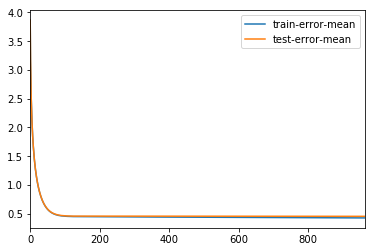

In [137]:
cv_output = xgb.cv(xgb_params,xgall, num_boost_round=2000,nfold=4,feval =RMSLE, maximize=False, 
                   early_stopping_rounds=150, verbose_eval=50, show_stdv=True, seed=33)
cv_output[['train-error-mean', 'test-error-mean']].plot()

In [ ]:
display (cv_output.head())
rounds = int(len(cv_output.index) * 1.05)
print(rounds)

In [ ]:
model = xgb.train(xgb_params, xgall, num_boost_round=rounds)

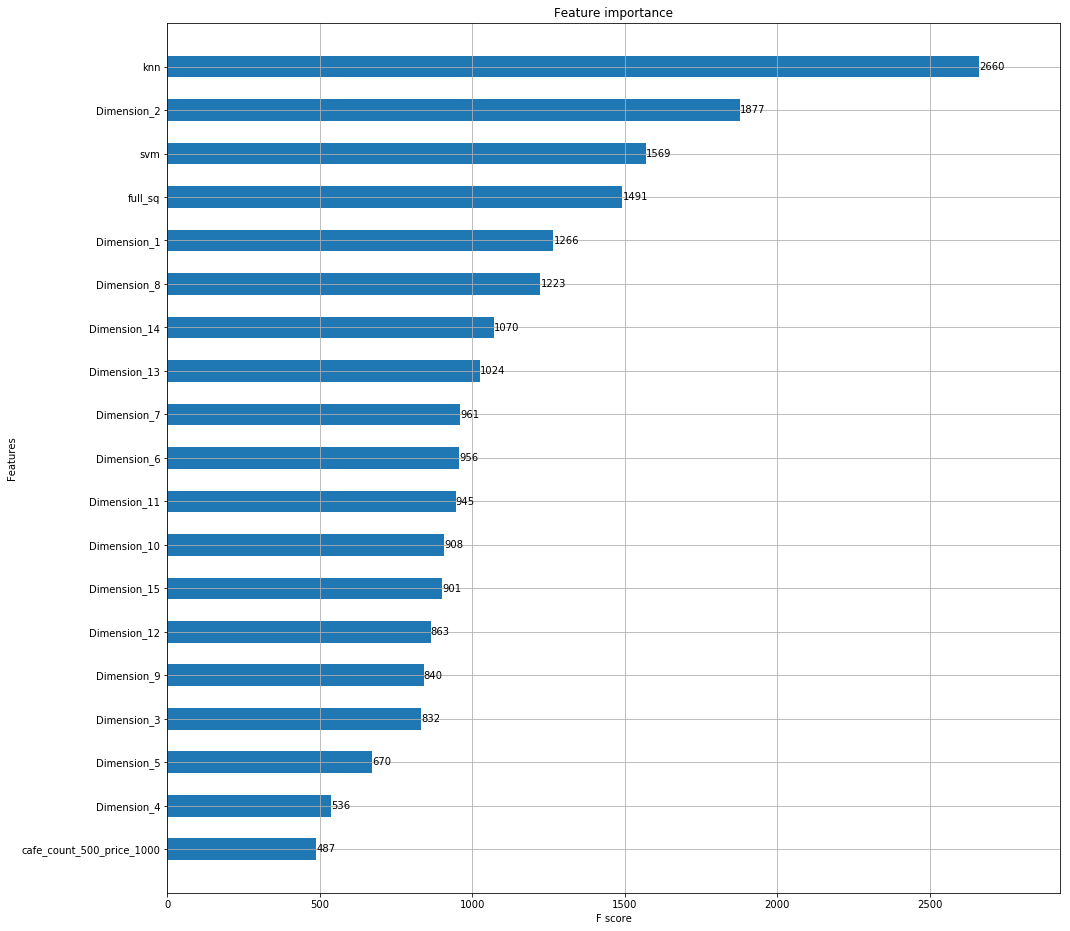

In [164]:
fig, ax = pl.subplots(1, 1, figsize=(16, 16))
xgb.plot_importance(model,  height=0.5, ax=ax)

In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
print('Build a model..')
Kr = KNeighborsRegressor()

xgbreg = XGBRegressor(max_depth = 5,min_child_weight=7,subsample= 0.87,
                                    colsample_bytree =0.47,learning_rate = 0.2,n_estimators =1200,
                                    missing = -99, seed =33)

from sklearn.pipeline import Pipeline

scaler = StandardScaler()
ridge = Ridge()
scalerridge = Pipeline([('scaler', scaler), ('ridge', ridge)])

scalerKr = Pipeline([('scaler', scaler), ('Kr', Kr)])

scalersvm = Pipeline([('scaler', scaler), ('lin', SVR(kernel='rbf'))])

svr_rbf = SVR(kernel='rbf')

stregr = StackingRegressor(regressors=[xgbreg, scalersvm], 
                           meta_regressor=svr_rbf, verbose=1)

In [ ]:
# Training the stacking classifier
print('fit a model..')
#stregr.fit(X_train, train_prices)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold,train_test_split

outer_cv = KFold(n_splits=5, shuffle=True, random_state=33)



Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, train_prices,test_size=0.3, random_state=33)

Xtest = pd.DataFrame(Xtest, columns = X_train.columns)
ytest = pd.DataFrame(ytest, columns =['price_doc'])
Xtest = Xtest.join(ytest)

Xtest = Xtest.sort_values('price_doc')
ytest = Xtest.price_doc
Xtest = Xtest.drop('price_doc', axis=1)

In [ ]:
'''
scalerKr = scalerKr.fit(Xtrain,ytrain)
kr_pred = scalerKr.predict(Xtest)
scalersvm = scalersvm.fit(Xtrain,ytrain)
svm_pred = scalersvm.predict(Xtest)
xgbreg = xgbreg.fit(Xtrain,ytrain)
xgb_pred = xgbreg.predict(Xtest)
svr_rbf = svr_rbf.fit(Xtrain,ytrain)
dt_pred = svr_rbf.predict(Xtest)
stregr = stregr.fit(Xtrain,ytrain)
streg_pred = stregr.predict(Xtest)
xg_pred = xgb.DMatrix(Xtest,feature_names = Xtest.columns )
mod_pred = model.predict(xg_pred)
'''

In [ ]:
#cv = cross_val_score(xgbreg,X_train, train_prices, scoring  = scoring, cv= 5)
#print (cv, np.mean(cv))

#cv = cross_val_score(scalerKr,X_train, train_prices, scoring  = scoring, cv= outer_cv)
#print (cv, np.mean(cv))

In [ ]:
#scalersvm = scalersvm.fit(X_train, train_prices)

In [ ]:
y = np.expm1(ytest)
x = range(0,len(y))
#axis = np.sort(np.array([x,y]))

y1 = np.expm1(svm_pred)
y2 = np.expm1(kr_pred)
y3 = np.expm1(xgb_pred)
y4 = np.expm1(dt_pred)
y5 = np.expm1(streg_pred)
y6 = np.expm1(mod_pred)


#y8 = np.mean( np.array([ y6, y1 ]), axis=0 )

pl.figure(figsize=(18,12))
pl.scatter(x,y,  c='r', alpha=0.6)
#pl.scatter(x, y1,  c='g', alpha=0.5)
#pl.scatter(x, y2,  c='y', alpha=0.6)
#pl.scatter(x, y3,  c='b', alpha=0.3)
#pl.scatter(x, y4,  c='m', alpha=0.5)
#pl.scatter(x, y5,  c='y', alpha=0.5)
pl.scatter(x, y6,  c='y', alpha=0.5)
#pl.plot(x_plot, y, 'r',x_plot, svm_pred, 'g',x_plot,kr_pred,'y',x_plot,xgb_pred,'b')
pl.axis([0, 9500, 1000,5e7])
#print(RMSE(y,y1))
print(RMSE(y,y6))
#print(RMSE(y,y8))
pl.show()

In [ ]:
#xgb grid search
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV  
from xgboost import XGBRegressor

param_test1 = {
 'max_depth':[5],
 'min_child_weight':[7],
 'subsample': [0.9],
 'colsample_bytree' :[0.1,0.3,0.5]
}

xgbreg_par = {'learning_rate' :0.5,'n_estimators' :200,  
              'colsample_bytree' : 1, 'missing' : -99, 'seed' :33}

gsearch1 = GridSearchCV(estimator = XGBRegressor(xgbreg_par),param_grid = param_test1,
                        scoring= 'neg_mean_squared_error', n_jobs= -1,iid=False, cv=5)
gsearch1.fit(X_train,train_prices)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [165]:
y_pred = model.predict(xg_submit)
                       #,ntree_limit=model.best_iteration)
#scaler_pred = scalersvm.predict(submit_features)

#ysub = np.mean( np.array([ y_pred, scaler_pred ]), axis=0 )

#y_submit = np.expm1(y_pred)

df_submit = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_submit.to_csv('submit.csv', index=False)